In [7]:
# Imports and settings
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from scipy.stats import ttest_ind, f_oneway, chi2_contingency, pearsonr

In [8]:
# Display options
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 120)
pd.set_option("display.float_format", lambda x: f"{x:.6e}")

# Plotting style
sns.set_theme(style='whitegrid', context='notebook', palette='Set2')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

DATA_PATH = '../../data/phase1-base-clean.csv'

# Load dataset
assert os.path.exists(DATA_PATH), f"File not found: {DATA_PATH}"

df = pd.read_csv(DATA_PATH)
df.head()

,age,sex,Chest pain type,trestbps,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,67,0,3,115,330,0,2,160,0,6.232809e-01,2,1
1,64,1,4,128,263,0,0,105,1,1.645005e-01,2,1
2,74,0,2,120,269,0,2,121,1,1.645005e-01,1,1
3,65,1,4,120,177,0,0,140,0,2.810958e-01,1,1
4,59,1,4,135,234,0,0,161,0,3.280635e-01,2,1


In [9]:
# Define target and continuous predictors
TARGET_COL = "target"
continuous_cols = ["age","trestbps","cholesterol","max heart rate", "oldpeak"]
categorical_cols = ["sex", "Chest pain type", "fasting blood sugar", "resting ecg", "exercise angina", "ST slope"]

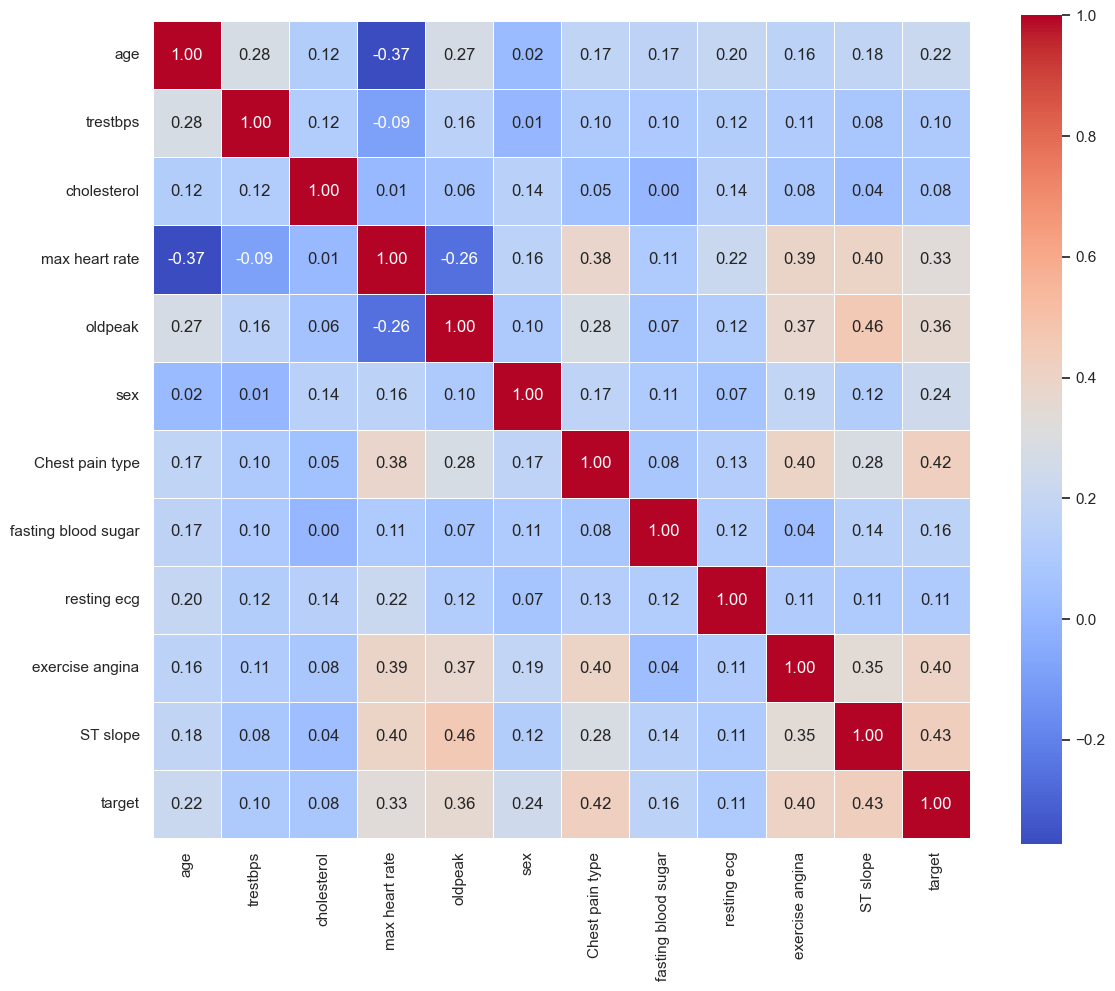

In [10]:
# Cramér’s V (categorical-categorical)
def cramers_v(x, y):
    contingency_table = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    phi2 = chi2 / n
    r, k = contingency_table.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Correlation Ratio (η²) for categorical-continuous 
def correlation_ratio(categories, values):
    cats = np.unique(categories)
    n_total = len(values)
    grand_mean = np.mean(values)
    ss_between = sum(len(values[categories == cat]) * (np.mean(values[categories == cat]) - grand_mean)**2 for cat in cats)
    ss_total = sum((v - grand_mean)**2 for v in values)
    return np.sqrt(ss_between / ss_total) if ss_total != 0 else 0

# Hybrid correlation matrix (with target)
def hybrid_corr(df, continuous_cols, categorical_cols, target_col):
    cols = continuous_cols + categorical_cols + [target_col]
    corr_matrix = pd.DataFrame(np.zeros((len(cols), len(cols))), index=cols, columns=cols)

    for i in range(len(cols)):
        for j in range(i, len(cols)):
            col_i, col_j = cols[i], cols[j]

            if col_i == col_j:
                corr_matrix.loc[col_i, col_j] = 1.0
            elif col_i in continuous_cols and col_j in continuous_cols:
                corr = df[[col_i, col_j]].corr(method="pearson").iloc[0, 1]
                corr_matrix.loc[col_i, col_j] = corr
                corr_matrix.loc[col_j, col_i] = corr
            elif col_i in categorical_cols and col_j in categorical_cols:
                corr = cramers_v(df[col_i], df[col_j])
                corr_matrix.loc[col_i, col_j] = corr
                corr_matrix.loc[col_j, col_i] = corr
            else:  # categorical-continuous
                if col_i in categorical_cols:
                    corr = correlation_ratio(df[col_i].values, df[col_j].values)
                else:
                    corr = correlation_ratio(df[col_j].values, df[col_i].values)
                corr_matrix.loc[col_i, col_j] = corr
                corr_matrix.loc[col_j, col_i] = corr

    return corr_matrix


hybrid_corr_matrix = hybrid_corr(df, continuous_cols, categorical_cols, TARGET_COL)

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(hybrid_corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True,
            linewidths=0.5, square=True)
plt.tight_layout()
plt.show()

T-test Results (Continuous Features Only):

                 T-statistic      p-value Significant (p<0.05)
oldpeak         1.582999e+01 1.348848e-52                  Yes
age             9.042128e+00 4.657306e-19                  Yes
trestbps        4.140583e+00 3.645269e-05                  Yes
cholesterol     3.239823e+00 1.221810e-03                  Yes
max heart rate -1.434557e+01 5.046834e-44                  Yes


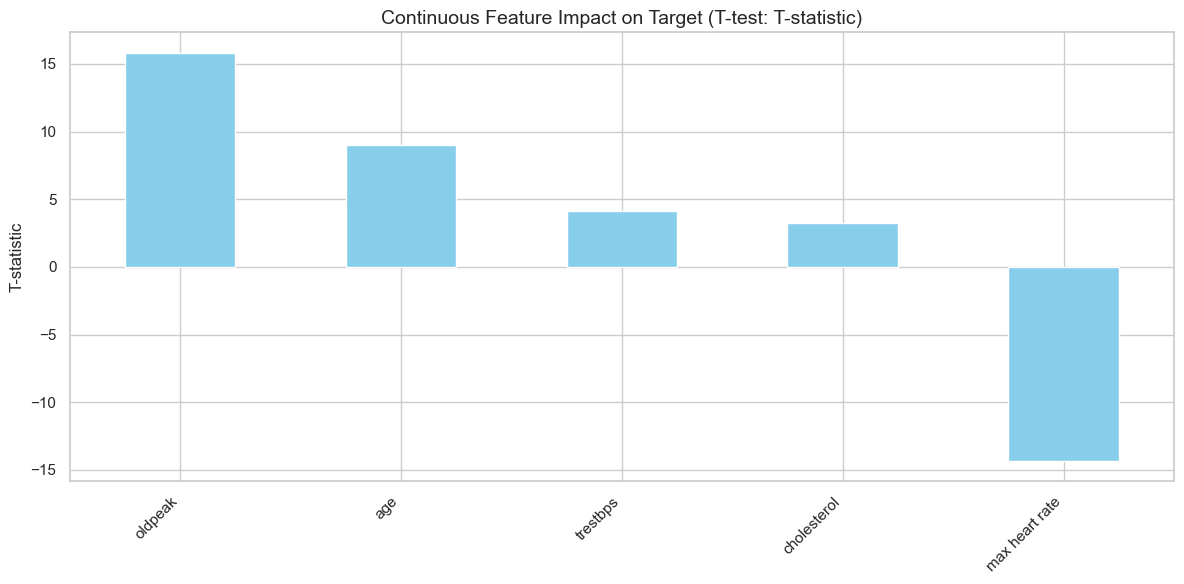

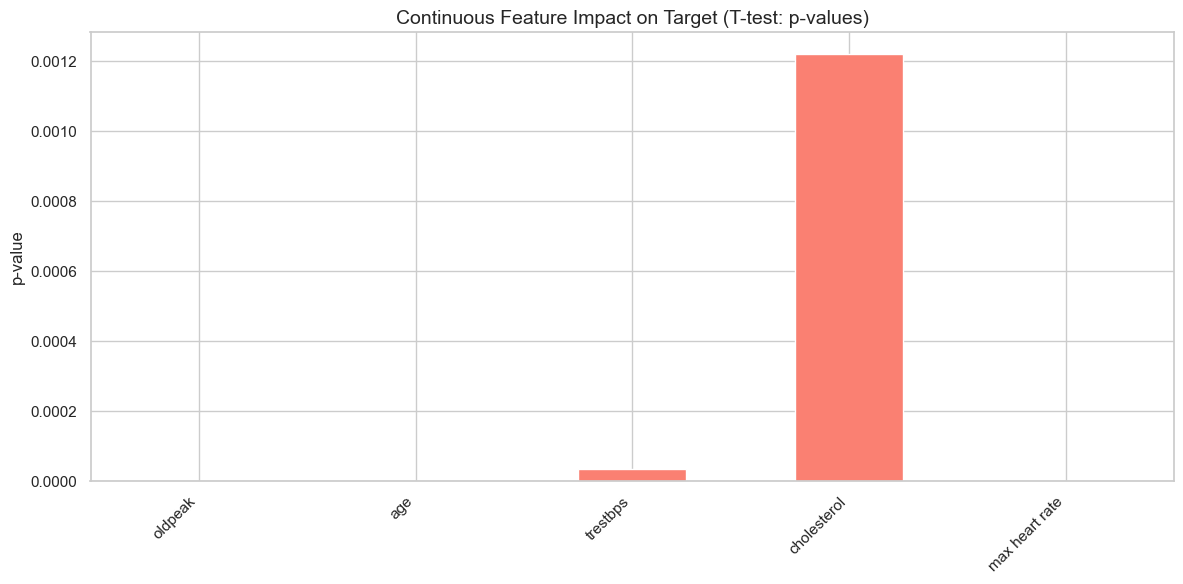

In [11]:
# Run t-test only for continuous predictors (binary target assumed)
t_results = {}

classes = df[TARGET_COL].unique()
if len(classes) != 2:
    raise ValueError("T-test requires exactly 2 classes in the target variable.")

for col in continuous_cols:
    group1 = df[df[TARGET_COL] == classes[0]][col]
    group2 = df[df[TARGET_COL] == classes[1]][col]
    
    stat, p = ttest_ind(group1, group2, equal_var=False)  # Welch's t-test (safer if variances differ)
    
    t_results[col] = {
        "T-statistic": stat,
        "p-value": p,
        "Significant (p<0.05)": "Yes" if p < 0.05 else "No"
    }

# Convert to DataFrame
t_df = pd.DataFrame(t_results).T.sort_values("T-statistic", ascending=False)
print("T-test Results (Continuous Features Only):\n")
print(t_df)

# Plot T-statistics
plt.figure(figsize=(12,6))
t_df["T-statistic"].plot(kind="bar", color="skyblue")
plt.title("Continuous Feature Impact on Target (T-test: T-statistic)")
plt.ylabel("T-statistic")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Plot p-values 
plt.figure(figsize=(12,6))
t_df["p-value"].plot(kind="bar", color="salmon")
plt.title("Continuous Feature Impact on Target (T-test: p-values)")
plt.ylabel("p-value")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Chi-Square Test Results (Categorical Features Only):

                    Chi2-statistic      p-value Significant (p<0.05)
ST slope              3.003089e+02 8.529214e-65                  Yes
Chest pain type       2.959288e+02 8.183974e-63                  Yes
exercise angina       2.616126e+02 7.638546e-59                  Yes
sex                   9.274511e+01 5.948215e-22                  Yes
fasting blood sugar   4.169315e+01 1.067824e-10                  Yes
resting ecg           1.970628e+01 5.258178e-05                  Yes


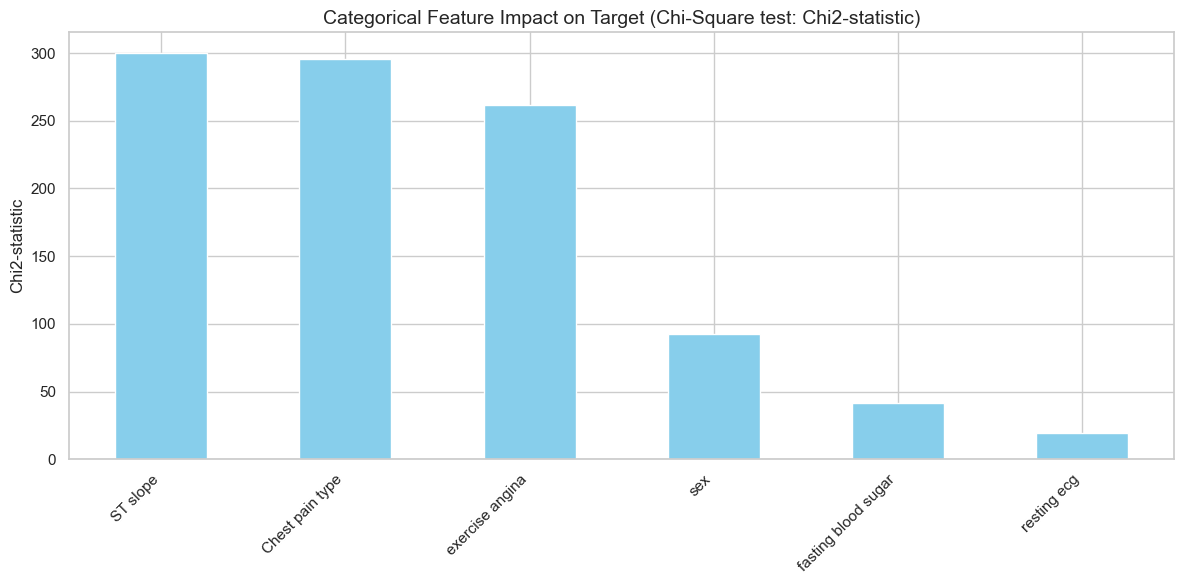

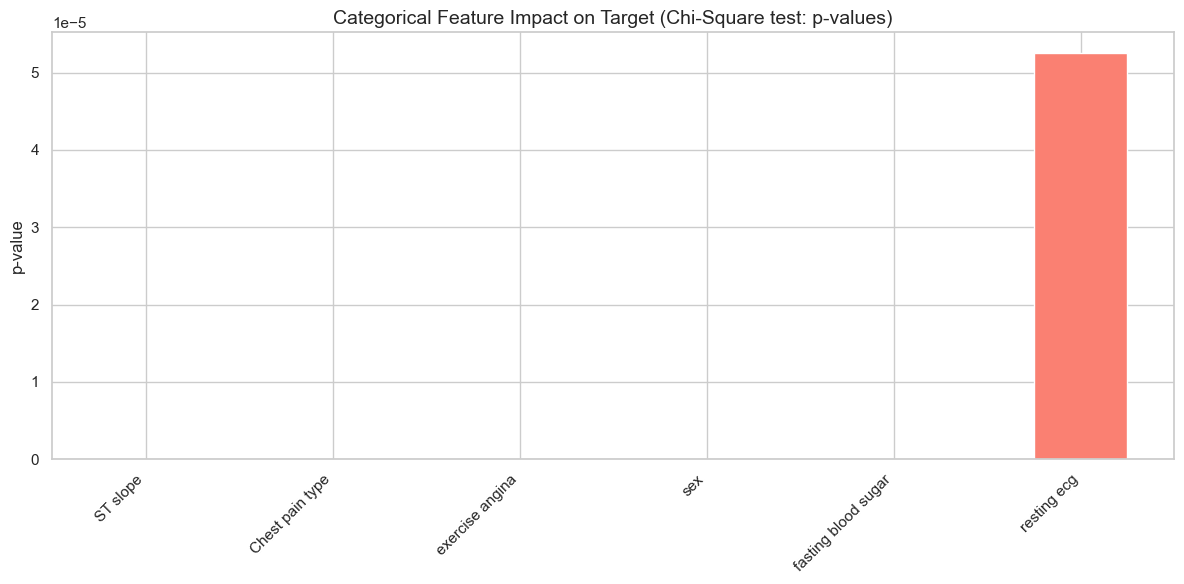

In [12]:
# Run Chi-Square test for categorical predictors
chi2_results = {}

for col in categorical_cols:
    contingency_table = pd.crosstab(df[col], df[TARGET_COL])
    
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    chi2_results[col] = {
        "Chi2-statistic": chi2,
        "p-value": p,
        "Significant (p<0.05)": "Yes" if p < 0.05 else "No"
    }

# Convert to DataFrame
chi2_df = pd.DataFrame(chi2_results).T.sort_values("Chi2-statistic", ascending=False)
print("Chi-Square Test Results (Categorical Features Only):\n")
print(chi2_df)

# Plot Chi2 statistics
plt.figure(figsize=(12,6))
chi2_df["Chi2-statistic"].plot(kind="bar", color="skyblue")
plt.title("Categorical Feature Impact on Target (Chi-Square test: Chi2-statistic)")
plt.ylabel("Chi2-statistic")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Plot p-values
plt.figure(figsize=(12,6))
chi2_df["p-value"].plot(kind="bar", color="salmon")
plt.title("Categorical Feature Impact on Target (Chi-Square test: p-values)")
plt.ylabel("p-value")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
